# High level steps that we will be performaing as part of this excercise

* Data sourcing and sentiment analysis
* Building a recommendation system based on different parameters
* Improving the recommendations using the best sentiment analysis model

# Importing the necessary libraries

In [1]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = spacy.load('en_core_web_sm',  disable=["parser", "ner"])
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

from nltk.tokenize import word_tokenize
from collections import Counter
import string
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer


from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from imblearn.over_sampling import SMOTE

# Import joblib to save and load the model
import joblib
from joblib import dump
import pickle

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import RocCurveDisplay

# Importing LogisticRegression from sklearn
from sklearn.linear_model import LogisticRegression

# Importing Random Forest Classifier from sklearn
from sklearn.ensemble import RandomForestClassifier

# importing libraries for XGBoost classifier
import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.metrics.pairwise import pairwise_distances

from pprint import pprint

C:\Users\Dell\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
# priniting import versions
import sklearn
print(sklearn.__version__)
print(np.__version__)
print(pd.__version__)
print(nltk.__version__)

1.0.2
1.26.4
1.4.4
3.7


# Loading the data

In [4]:
df = pd.read_csv("sample30.csv")

# Exploratory Data Analysis

In [5]:
df.shape

(30000, 15)

In [6]:
# Inspect the dataframe to understand the given data.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   name                  30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
 14  user_sentiment        29999 non-null  object
dtypes: int64(1), object(14)
memory usage

In [7]:
# Print top 5 rows of the data
df.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,Negative


# Data Cleaning

### Handling NULL values

In [8]:
# Creating copy of the dataframe
df_cp = df.copy()

In [9]:
# Checking for NULL values
null_columns = df_cp.columns[df_cp.isna().any()]
null_cnt = df_cp[null_columns].isna().sum().sort_values(ascending=False)
null_percent = (null_cnt * 100 / df_cp.shape[0]).sort_values(ascending=False)
null_data = pd.DataFrame({'Count': null_cnt, 'Percentage': null_percent})
null_data

,Count,Percentage
reviews_userProvince,29830,99.433333
reviews_userCity,28071,93.570000
reviews_didPurchase,14068,46.893333
reviews_doRecommend,2570,8.566667
reviews_title,190,0.633333
manufacturer,141,0.470000
reviews_username,63,0.210000
reviews_date,46,0.153333
user_sentiment,1,0.003333


**Our Observations:**
1. `reviews_userProvince` and `reviews_userCity` have over 93% NULL values so we can remove them from the dataset.
2. `reviews_didPurchase` column has over 46% NULL values and is not useful in building of the Sentiment/Recommender system so can be removed.



In [10]:
df_clean = df_cp.copy()


In [11]:
df_clean.drop(columns=['reviews_userProvince','reviews_userCity','reviews_didPurchase'], inplace=True)

In [12]:
df_clean.shape

(30000, 12)

In [13]:
# Checking for NULL values again
null_columns = df_clean.columns[df_clean.isna().any()]
null_counts = df_clean[null_columns].isna().sum().sort_values(ascending=False)
null_percentages = (null_counts * 100 / df_clean.shape[0]).sort_values(ascending=False)
null_data = pd.DataFrame({'Count': null_counts, 'Percentage': null_percentages})
null_data

,Count,Percentage
reviews_doRecommend,2570,8.566667
reviews_title,190,0.633333
manufacturer,141,0.470000
reviews_username,63,0.210000
reviews_date,46,0.153333
user_sentiment,1,0.003333


#### Checking `reviews_doRecommend` column

In [14]:
df_clean.reviews_doRecommend.value_counts(normalize=True)

True     0.943493
False    0.056507
Name: reviews_doRecommend, dtype: float64

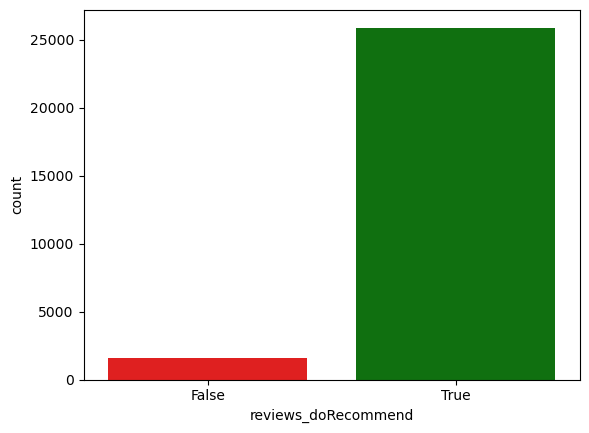

In [15]:
# Plotting the chart
sns.countplot(x = 'reviews_doRecommend', data = df_clean,palette=['r', 'g'])
plt.show()

From the distribution of `reviews_doRecommend` column, we can see that more than 94% of the data is having True value so dropping this field

In [16]:
df_clean.drop(columns=['reviews_doRecommend'], inplace=True)

In [17]:
null_columns = df_clean.columns[df_clean.isna().any()]
null_counts = df_clean[null_columns].isna().sum().sort_values(ascending=False)
null_percentages = (null_counts * 100 / df_clean.shape[0]).sort_values(ascending=False)
null_data = pd.DataFrame({'Count': null_counts, 'Percentage': null_percentages})
null_data

,Count,Percentage
reviews_title,190,0.633333
manufacturer,141,0.470000
reviews_username,63,0.210000
reviews_date,46,0.153333
user_sentiment,1,0.003333


#### Handling NULL values in reviews_title column

In [18]:
df_clean = df_clean[~ df_clean.reviews_title.isna() ]

In [19]:
# Checking rowcount post deletion
df_clean.shape

(29810, 11)

In [20]:
# Checking NULL values again
null_columns = df_clean.columns[df_clean.isna().any()]
null_counts = df_clean[null_columns].isna().sum().sort_values(ascending=False)
null_percentages = (null_counts * 100 / df_clean.shape[0]).sort_values(ascending=False)
null_data = pd.DataFrame({'Count': null_counts, 'Percentage': null_percentages})
null_data

,Count,Percentage
manufacturer,141,0.472996
reviews_username,62,0.207984
reviews_date,46,0.154311
user_sentiment,1,0.003355


#### Handling NULL values in reviews_username column

In [21]:
df_clean = df_clean[~ df_clean.reviews_username.isna() ]

In [22]:
# Checking rowcount post deletion
df_clean.shape

(29748, 11)

In [23]:
# Checking NULL values again
null_columns = df_clean.columns[df_clean.isna().any()]
null_counts = df_clean[null_columns].isna().sum().sort_values(ascending=False)
null_percentages = (null_counts * 100 / df_clean.shape[0]).sort_values(ascending=False)
null_data = pd.DataFrame({'Count': null_counts, 'Percentage': null_percentages})
null_data

,Count,Percentage
manufacturer,141,0.473981
reviews_date,40,0.134463
user_sentiment,1,0.003362


#### Handling NULL values in user_sentiment column

In [24]:
df_clean.user_sentiment.value_counts()

Positive    26412
Negative     3335
Name: user_sentiment, dtype: int64

In [25]:
df_clean[ df_clean.user_sentiment.isna() ].user_sentiment

28354    NaN
Name: user_sentiment, dtype: object

In [26]:
df_clean.user_sentiment.fillna('Positive', inplace=True)

In [27]:
# Checking NULL values again
null_columns = df_clean.columns[df_clean.isna().any()]
null_counts = df_clean[null_columns].isna().sum().sort_values(ascending=False)
null_percentages = (null_counts * 100 / df_clean.shape[0]).sort_values(ascending=False)
null_data = pd.DataFrame({'Count': null_counts, 'Percentage': null_percentages})
null_data

,Count,Percentage
manufacturer,141,0.473981
reviews_date,40,0.134463


The columns `manufacturer` and `reviews_date` are not needed for the Sentiment and Recommender models so we will not handle the NULL values for them.

In [28]:
# Check the data for top 5 rows
df_clean.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,5,i love this album. it's very good. more to the...,Just Awesome,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,5,Good flavor. This review was collected as part...,Good,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,5,Good flavor.,Good,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,1,I read through the reviews on here before look...,Disappointed,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,1,My husband bought this gel for us. The gel cau...,Irritation,walker557,Negative


# Data Analysis

#### Checking Distribution of `reviews_rating` column

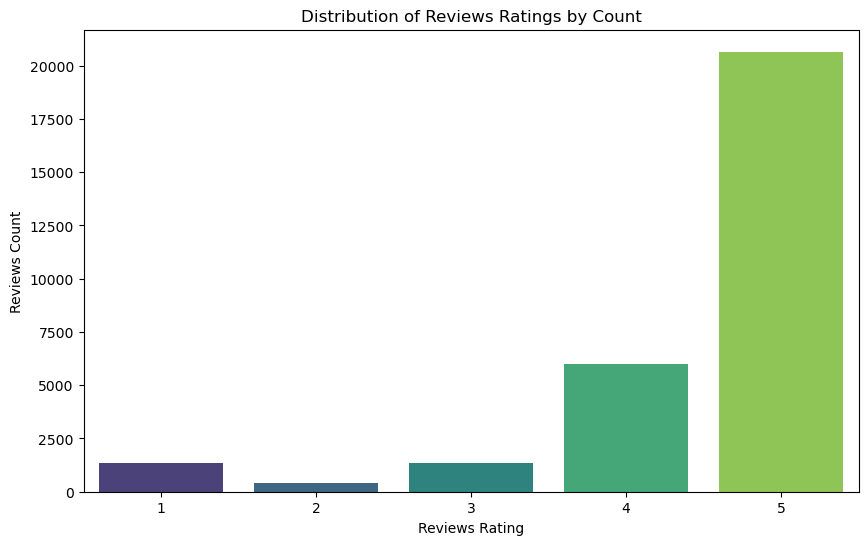

In [29]:
plt.figure(figsize=(10, 6))
sns.countplot(x='reviews_rating', data=df_clean, palette='viridis', hue_order=[1, 2, 3, 4, 5])
plt.title('Distribution of Reviews Ratings by Count')
plt.xlabel('Reviews Rating')
plt.ylabel('Reviews Count')
plt.show()


Many users have given ratings on the higher side, with a majority rating of 5. This imbalance in ratings could affect the alignment of user_sentiment with the ratings. 

#### Checking Top 5 Brands with Negative reviews

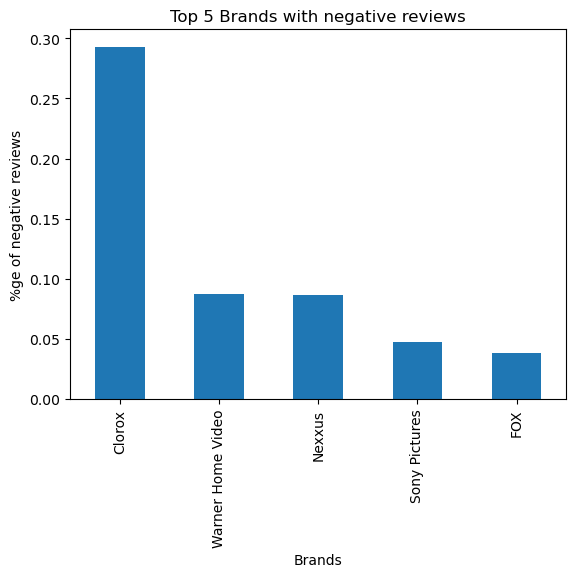

In [30]:
# Filter DataFrame for rows with 'Negative' sentiment
negative_reviews = df_clean[df_clean['user_sentiment'] == 'Negative']

# Get the value counts of 'brand' column, normalize them, and get the top 5
top_negative_brands = negative_reviews['brand'].value_counts(normalize=True, ascending=False).head(5)

# Plot the top 5 brands with negative reviews
top_negative_brands.plot(kind='bar')
plt.title("Top 5 Brands with negative reviews")
plt.xlabel("Brands")
plt.ylabel("%ge of negative reviews")
plt.show()

`Clorox` is the product that is rated as most negative and almost 30% of the negative reviews have been given for `Clorox`.

#### Checking Top 5 Brands with Positive reviews

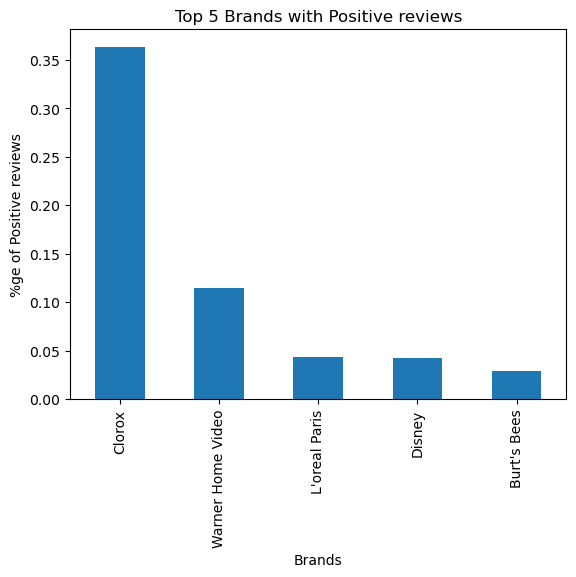

In [31]:
(
    df_clean
    .loc[df_clean['user_sentiment'] == 'Positive', 'brand']
    .value_counts(normalize=True, ascending=False)
    .head(5)
    .plot(kind='bar')
)
plt.title("Top 5 Brands with Positive reviews")
plt.xlabel("Brands")
plt.ylabel("%ge of Positive reviews")
plt.show()

In [32]:
df_clean.brand.value_counts(normalize=True).head(5)

Clorox               0.355116
Warner Home Video    0.111739
Disney               0.040238
L'oreal Paris        0.039868
FOX                  0.029817
Name: brand, dtype: float64

* `Clorox` is the product which is rated the most positive as well and more than 35% of the positive reviews have been for `Clorox`.
* 35% of the brands for which we have the data is actually `Clorox` hence it has the most reviews.

### Checking review counts based on the review year

In [33]:
df_clean['reviews_date'] = pd.to_datetime(df_clean['reviews_date'], errors='coerce')

In [34]:
# After type conversion
df_clean.reviews_date.dtype

datetime64[ns, UTC]

In [35]:
# Getting the year component from date
df_clean.reviews_date.dt.year

0        2012.0
1        2017.0
2        2017.0
3        2016.0
4        2016.0
          ...  
29995    2017.0
29996    2017.0
29997    2017.0
29998    2017.0
29999    2017.0
Name: reviews_date, Length: 29748, dtype: float64

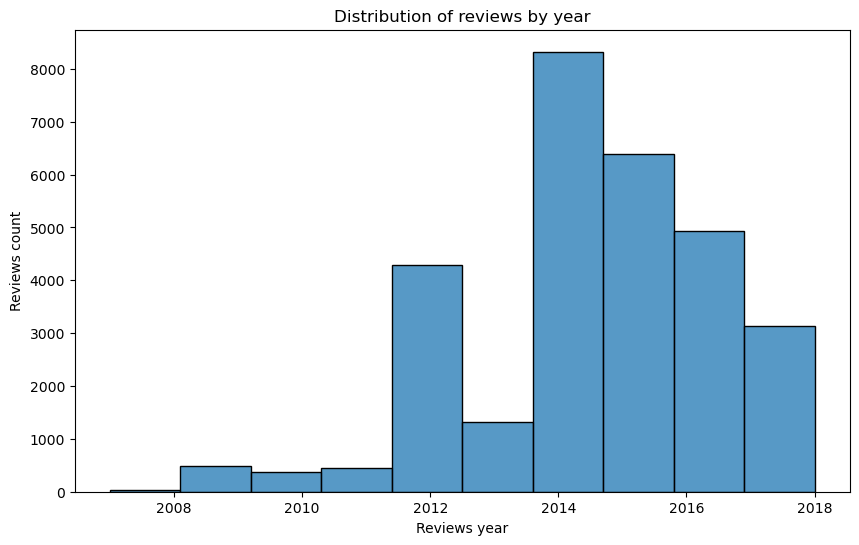

In [36]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df_clean, x=df_clean.reviews_date.dt.year, bins=10, kde=False)
plt.title("Distribution of reviews by year")
plt.xlabel("Reviews year")
plt.ylabel("Reviews count")
plt.show()

#### Checking the categories by Rating

<Figure size 800x400 with 0 Axes>

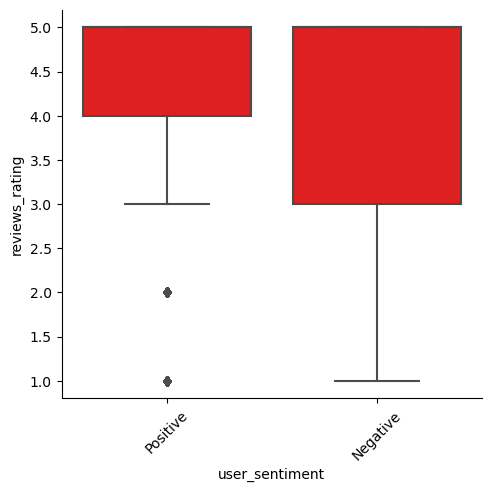

In [37]:
plt.figure(figsize=(8, 4))
sns.catplot(data=df_clean, x='user_sentiment', y='reviews_rating', kind='box', color='red')
plt.xticks(rotation=45)
plt.tight_layout(pad=1)
plt.show()

In [38]:
df_clean.query("user_sentiment == 'Negative' and reviews_rating >= 4").groupby('reviews_rating').size()


reviews_rating
4     548
5    1848
dtype: int64

* There are brands which have Negative sentiments but much higher review ratings (4 or 5). 

# Type Conversion

In [39]:
# Convert all the text columns to string for performing text operations
df_clean['brand'] = df_clean['brand'].astype(str)
df_clean['categories'] = df_clean['categories'].astype(str)
df_clean['manufacturer'] = df_clean['manufacturer'].astype(str)
df_clean['name'] = df_clean['name'].astype(str)
df_clean['reviews_text'] = df_clean['reviews_text'].astype(str)
df_clean['reviews_title'] = df_clean['reviews_title'].astype(str)
df_clean['reviews_username'] = df_clean['reviews_username'].astype(str)

In [40]:
text_columns = ['brand', 'categories', 'manufacturer', 'name', 'reviews_text', 'reviews_title', 'reviews_username']
df_clean[text_columns] = df_clean[text_columns].applymap(str)

# Pre-Processing

In [41]:
# Creating a copy of clean dataframe for pre-processing
df_prep = df_clean.copy()

#### Combining `reviews_text` and `reviews_title` columns into `reviews_combined` and dropping the initial fields

In [42]:
df_prep = df_prep.assign(reviews_combined=df_prep['reviews_text'] + " " + df_prep['reviews_title']).drop(columns=['reviews_text', 'reviews_title'])

In [43]:
df_prep.shape

(29748, 10)

In [44]:
df_prep.head(1)

,id,brand,categories,manufacturer,name,reviews_date,reviews_rating,reviews_username,user_sentiment,reviews_combined
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30 06:21:45+00:00,5,joshua,Positive,i love this album. it's very good. more to the...


### Removing the columns which are not needed for our analysis

In [45]:
df_prep.drop(columns=['categories', 'manufacturer', 'reviews_date'], inplace=True)

In [46]:
df_prep.head(1)

,id,brand,name,reviews_rating,reviews_username,user_sentiment,reviews_combined
0,AV13O1A8GV-KLJ3akUyj,Universal Music,Pink Friday: Roman Reloaded Re-Up (w/dvd),5,joshua,Positive,i love this album. it's very good. more to the...


### Creating the dataframe for Sentiment analysis with the required columns

In [47]:
df_sentim = df_prep[['id','name','reviews_combined', 'user_sentiment']]

In [48]:
df_sentim.shape

(29748, 4)

In [49]:
df_sentim.head(2)

,id,name,reviews_combined,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Pink Friday: Roman Reloaded Re-Up (w/dvd),i love this album. it's very good. more to the...,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,Good flavor. This review was collected as part...,Positive


#### Handling the Punctuations

In [50]:
# Function to clean the text and remove all the unnecessary elements.
def clean_punctuation(sent):
    sent = sent.lower()  # Convert text to lowercase
    translator = str.maketrans('', '', string.punctuation)  # Translator to remove punctuation
    sent = sent.translate(translator)  # Remove punctuation
    return sent

In [51]:
df_sentim['reviews_cleaned'] = df_sentim['reviews_combined'].apply(clean_punctuation)

In [52]:
df_sentim.head(2)

,id,name,reviews_combined,user_sentiment,reviews_cleaned
0,AV13O1A8GV-KLJ3akUyj,Pink Friday: Roman Reloaded Re-Up (w/dvd),i love this album. it's very good. more to the...,Positive,i love this album its very good more to the hi...
1,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,Good flavor. This review was collected as part...,Positive,good flavor this review was collected as part ...


#### Handling the Stopwords

In [53]:
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords_set = set(stopwords.words("english"))
print(stopwords_set)

{'what', 'below', 'once', 'themselves', 'yourselves', 'such', 'itself', 'have', 'didn', 'where', 'hadn', "couldn't", 'am', 'are', 'has', 'its', 'yourself', 'as', "she's", 'about', 'a', 'few', 'there', 'was', 'can', 'she', 'each', 'through', 'having', 'by', 'whom', 've', 'from', 'haven', "mightn't", "isn't", 'above', 'other', 'ain', 'wasn', "hasn't", 'hasn', 'no', 'when', "shan't", 'wouldn', "don't", 'y', 'during', 'any', 'we', 'up', 'himself', 'same', 'before', "you've", 'own', 's', 'with', 'me', "needn't", 'just', 'don', 'isn', 'his', 'some', 'mustn', 'had', 'doing', 'aren', 'ma', 'yours', 'than', 'm', 'then', 'for', 'out', 't', 'ourselves', 'after', 'him', 'down', 'is', 'that', "shouldn't", 'this', "mustn't", 'off', 'more', 'how', 'needn', 'shan', 'll', 'why', "won't", 'but', "didn't", 'in', 'your', 'her', 'again', 'hers', 'between', 'it', 'myself', 'to', 'only', "wasn't", 'on', 'against', "wouldn't", 'an', 'until', 'will', 'at', 'my', "that'll", 'i', 'were', "hadn't", 'them', 'might

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [54]:
# Function to remove the stopwords
def clean_stopwords(sent):
    sent = sent.lower() # Text to lowercase
    words = word_tokenize(sent) # Split sentences into words
    text_nostopwords = " ".join( [each_word for each_word in words if each_word not in stopwords_set] )
    return sent

In [55]:
df_sentim['reviews_cleaned'] = df_sentim['reviews_cleaned'].apply(clean_stopwords)

In [56]:
df_sentim.head(2)

,id,name,reviews_combined,user_sentiment,reviews_cleaned
0,AV13O1A8GV-KLJ3akUyj,Pink Friday: Roman Reloaded Re-Up (w/dvd),i love this album. it's very good. more to the...,Positive,i love this album its very good more to the hi...
1,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,Good flavor. This review was collected as part...,Positive,good flavor this review was collected as part ...


#### Handling the lemmatization

In [57]:
#Function to lemmatize the text
def clean_lemma(text):
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc]
    return " ".join(lemmas)

In [58]:
df_sentim['reviews_lemmatized'] = df_sentim['reviews_cleaned'].apply(clean_lemma)

In [59]:
df_sentim.head(2)

,id,name,reviews_combined,user_sentiment,reviews_cleaned,reviews_lemmatized
0,AV13O1A8GV-KLJ3akUyj,Pink Friday: Roman Reloaded Re-Up (w/dvd),i love this album. it's very good. more to the...,Positive,i love this album its very good more to the hi...,I love this album its very good more to the hi...
1,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,Good flavor. This review was collected as part...,Positive,good flavor this review was collected as part ...,good flavor this review be collect as part of ...


In [60]:
df_sentim = df_sentim[['id','name','reviews_lemmatized', 'user_sentiment']]

In [61]:
df_sentim.head(2)

,id,name,reviews_lemmatized,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Pink Friday: Roman Reloaded Re-Up (w/dvd),I love this album its very good more to the hi...,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,good flavor this review be collect as part of ...,Positive


In [62]:
df_sentim.shape

(29748, 4)

In [63]:
# Saving the the cleaned dataframe
joblib.dump(df_sentim, "./models/clean_data.pkl")

['./models/clean_data.pkl']

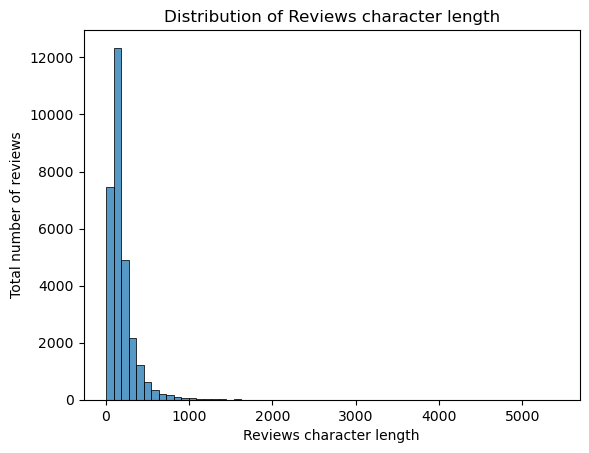

In [64]:
# Calculate character length of each review
review_lengths = [len(review) for review in df_sentim['reviews_lemmatized']]

# Plot the distribution of review lengths
sns.histplot(review_lengths, bins=60, kde=False, palette="viridis")
plt.xlabel("Reviews character length")
plt.ylabel("Total number of reviews")
plt.title("Distribution of Reviews character length")
plt.show()

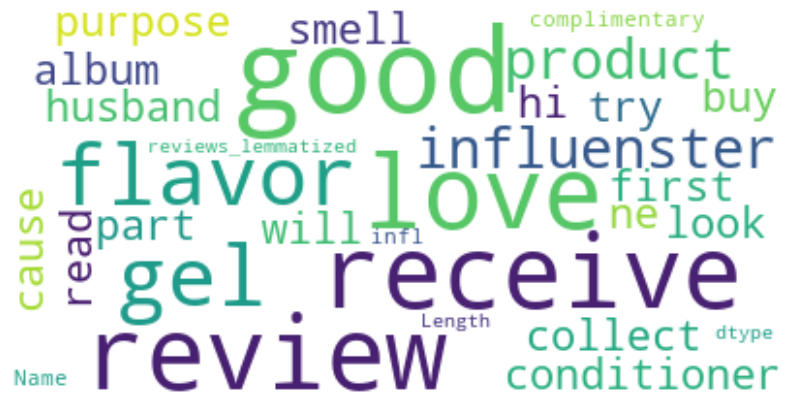

In [65]:
#Using a word cloud visualize the top 30 words in review by frequency
stopwords_wordcloud = set(STOPWORDS)
wordcloud = WordCloud(max_font_size=60, max_words=30, 
                      background_color="white", random_state=42, 
                      stopwords=stopwords_wordcloud).generate(str(df_sentim['reviews_lemmatized']))
plt.figure(figsize=[10,10])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Feature Extraction

## TF-IDF Feature Extraction

In [66]:
# Initialize the TfidfVectorizer 
tfidf = TfidfVectorizer(min_df=5, max_df=0.95, stop_words='english', ngram_range=(1,2))

In [67]:
X = tfidf.fit_transform(df_sentim['reviews_lemmatized'])

y= df_sentim['user_sentiment']

In [68]:
# Saving the the tfidf vectorizer model
pickle.dump(tfidf, open("./models/tfidf.pkl","wb"))

### Split for Train and Test

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25)

In [70]:
print("Train shapes:", X_train.shape, y_train.shape)
print("Test shapes:", X_test.shape, y_test.shape)

Train shapes: (22311, 16036) (22311,)
Test shapes: (7437, 16036) (7437,)


### Showing Class Imbalance

In [71]:
# Check the data to see if there is a class imbalance in the data
df_sentim['user_sentiment'].value_counts(normalize=True)

Positive    0.887892
Negative    0.112108
Name: user_sentiment, dtype: float64

In [72]:
df_sentim.head(2)

,id,name,reviews_lemmatized,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Pink Friday: Roman Reloaded Re-Up (w/dvd),I love this album its very good more to the hi...,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,good flavor this review be collect as part of ...,Positive



> Positive sentiments form approx *89%* of the data and Negative sentiments approx *11%*

In [73]:
counter = Counter(y_train)
print("Before handling data imbalance", counter)

#oversampling with SMOTE
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train,y_train)

counter = Counter(y_train_sm)
print("After handling data imbalance", counter)

Before handling data imbalance Counter({'Positive': 19786, 'Negative': 2525})
After handling data imbalance Counter({'Positive': 19786, 'Negative': 19786})


# Model Building

In [74]:
# Custom Function to display scores
def eval_scores(classifier, X_test, y_test):

  # Calculating Predicted value
  y_pred = classifier.predict(X_test)

  # Create confusion matrix
  conf_m = confusion_matrix(y_test, y_pred)

  print("Visualizing the Confusion Matrix with a Heatmap")
  print("\n")
  print("*"*50)
  # Visualize Confusion Matrix with heatmap
  fig, ax = plt.subplots(figsize=(6, 6))
  ax = sns.heatmap(confusion_matrix(y_test, y_pred),
                  annot=True,
                  cbar=False,
                  cmap="RdYlGn", fmt = '0.1f')
  plt.xlabel("Actual label")
  plt.ylabel("Predicted label")
  plt.show()
  print("*"*50)
  print("\n")

  # Calculating the values of True Positives, True Negatives, False Positivies and False Negatives
  TP = conf_m[1][1]
  TN = conf_m[0][0]
  FP = conf_m[0][1]
  FN = conf_m[1][0]

  print("Values of True Positives, True Negatives, False Positivies and False Negatives")
  print("~"*50)
  print('True Positives:', TP)
  print('True Negatives:', TN)
  print('False Positives:', FP)
  print('False Negatives:', FN)
  print("~"*50)
  print("\n")

  # Calculating Accuracy
  accuracy = accuracy_score(y_test, y_pred)
  accuracy = round(accuracy,2)
  
  # Calculating Sensitivity/Recall
  sensitivity_recall = (TP / float(TP + FN))
  sensitivity_recall = round(sensitivity_recall,2)
  
  # Calculating Specificity
  specificity = (TN / float(TN + FP))
  specificity = round(specificity,2)  
  
  # Calculating Precision
  precision = (TN / float(TN + FP))
  precision = round(precision,2)  
  
  # Calculating F_1 score
  F1_score = 2 * ((precision * sensitivity_recall) / (precision + sensitivity_recall))
  F1_score = round(F1_score,2)  
  
  print("Evaluation Score Summary")
  print('-'*50)
  print(f'Accuracy Score: {round(accuracy,2)}')
  print(f'Sensitivity/Recall Score: {round(sensitivity_recall,2)}') 
  print(f'Specificity Score: {round(specificity,2)}') 
  print(f'Precision: {round(precision,2)}')
  print(f'F1 Score: {round(F1_score,2)}')
  print('-'*50)

  # Returning evaluation results for comparison later
  eval_metrics = []
  eval_metrics.append(accuracy)
  eval_metrics.append(sensitivity_recall)
  eval_metrics.append(specificity)
  eval_metrics.append(precision)
  eval_metrics.append(F1_score)
  
  return eval_metrics

## `Logistic Regression`

In [75]:
logreg = LogisticRegression(random_state=42, solver='liblinear').fit(X_train_sm, y_train_sm)

Visualizing the Confusion Matrix with a Heatmap


**************************************************


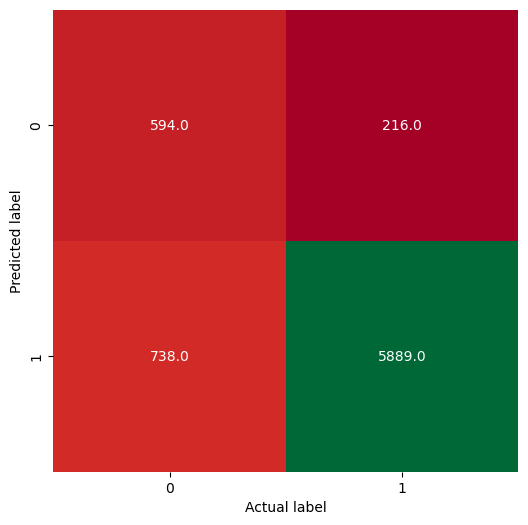

**************************************************


Values of True Positives, True Negatives, False Positivies and False Negatives
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True Positives: 5889
True Negatives: 594
False Positives: 216
False Negatives: 738
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Evaluation Score Summary
--------------------------------------------------
Accuracy Score: 0.87
Sensitivity/Recall Score: 0.89
Specificity Score: 0.73
Precision: 0.73
F1 Score: 0.8
--------------------------------------------------


In [76]:
# Getting the score of the base model
lr_metrics = eval_scores(logreg, X_test, y_test)

In [77]:
# Printing the scores of the base model as reference
df_lr_base_metrics = pd.DataFrame({'Metrics': ['Accuracy','Sensitivity/Recall','Specificity','Precision','F1 Score'], 'Logistic Regression Base Model': lr_metrics},
                             columns = ['Metrics', 'Logistic Regression Base Model']
                             )
df_lr_base_metrics

,Metrics,Logistic Regression Base Model
0,Accuracy,0.87
1,Sensitivity/Recall,0.89
2,Specificity,0.73
3,Precision,0.73
4,F1 Score,0.80


In [78]:
logreg_grid = {"C": [100, 10, 5, 4, 3, 2, 1, 1.0, 0.1, 0.01],
                "solver": ["liblinear"]}

In [79]:
# Setup grid hyperparameter search for LogisticRegression
logreg_hpt = GridSearchCV(LogisticRegression(random_state=42),
                                param_grid=logreg_grid,
                                cv=5,
                                verbose=True,
                                n_jobs=-1)

# Fit random hyperparameter search model
logreg_hpt.fit(X_train_sm, y_train_sm)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid={'C': [100, 10, 5, 4, 3, 2, 1, 1.0, 0.1, 0.01],
                         'solver': ['liblinear']},
             verbose=True)

In [80]:
# Checking the best parameters
logreg_hpt.best_params_

{'C': 100, 'solver': 'liblinear'}

### HyperParameter Tuned LR Model

Visualizing the Confusion Matrix with a Heatmap


**************************************************


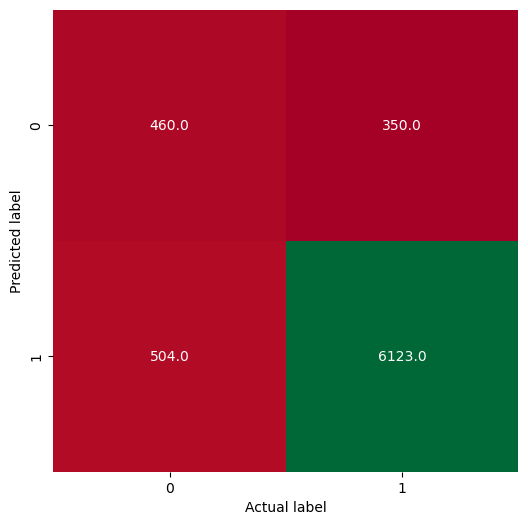

**************************************************


Values of True Positives, True Negatives, False Positivies and False Negatives
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True Positives: 6123
True Negatives: 460
False Positives: 350
False Negatives: 504
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Evaluation Score Summary
--------------------------------------------------
Accuracy Score: 0.89
Sensitivity/Recall Score: 0.92
Specificity Score: 0.57
Precision: 0.57
F1 Score: 0.7
--------------------------------------------------


In [81]:
# Getting the scores of the tuned model
lr_tuned_metrics = eval_scores(logreg_hpt, X_test, y_test)

In [82]:
# Printing the scores of the base and tuned Logistic Regression model for reference
dict_lr_bt_metrics = {'Metrics': ['Accuracy','Sensitivity/Recall','Specificity','Precision','F1 Score'], 
                               'LR Base Model': lr_metrics,
                               'LR Tuned Model': lr_tuned_metrics}

df_lr_bt_metrics = pd.DataFrame(dict_lr_bt_metrics, columns = ['Metrics', 'LR Base Model', 'LR Tuned Model'])
df_lr_bt_metrics

,Metrics,LR Base Model,LR Tuned Model
0,Accuracy,0.87,0.89
1,Sensitivity/Recall,0.89,0.92
2,Specificity,0.73,0.57
3,Precision,0.73,0.57
4,F1 Score,0.80,0.70


### Saving the base and tuned models

In [83]:
lr_base_model = dump(logreg, './pickle/lr_base_model.joblib')

In [84]:
lr_tuned_model = dump(logreg_hpt, './pickle/lr_base_model.joblib')

***Conclusion:***
* For Logistic Regression, Base Model is performing better than the tuned model.
* We will consider the Base Model for evaluation purpose during model comparison.

## `Random Forest Classifier`

In [85]:
rf = RandomForestClassifier(random_state=42).fit(X_train_sm, y_train_sm)

Visualizing the Confusion Matrix with a Heatmap


**************************************************


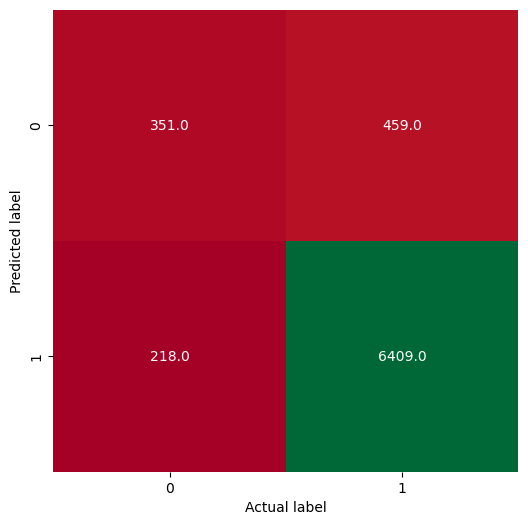

**************************************************


Values of True Positives, True Negatives, False Positivies and False Negatives
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True Positives: 6409
True Negatives: 351
False Positives: 459
False Negatives: 218
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Evaluation Score Summary
--------------------------------------------------
Accuracy Score: 0.91
Sensitivity/Recall Score: 0.97
Specificity Score: 0.43
Precision: 0.43
F1 Score: 0.6
--------------------------------------------------


In [86]:
# Getting the score of the base model
rf_metrics = eval_scores(rf, X_test, y_test)

In [87]:
# Printing the scores of the base model as reference
df_rf_base_metrics = pd.DataFrame({'Metrics': ['Accuracy','Sensitivity/Recall','Specificity','Precision','F1 Score'], 'RF Base Model': rf_metrics},
                             columns = ['Metrics', 'RF Base Model']
                             )
df_rf_base_metrics

,Metrics,RF Base Model
0,Accuracy,0.91
1,Sensitivity/Recall,0.97
2,Specificity,0.43
3,Precision,0.43
4,F1 Score,0.60


***Sensitivity and Accuracy are high but Specificity and Precision are low.*** 

In [88]:
rf_grid = {"n_estimators": np.arange(10, 1000, 50),
           "max_depth": np.arange(10, 50, 5),
           "min_samples_split": np.arange(15, 500, 15),
           "min_samples_leaf": np.arange(5, 50, 5)}

In [89]:
# Setting up random hyperparameter search for Random Forest Classifier
rf_hpt = RandomizedSearchCV(RandomForestClassifier(random_state=42),
                                param_distributions=rf_grid,
                                cv=5,
                                verbose=True,
                                n_jobs=-1)

# Fit random hyperparameter search model
rf_hpt.fit(X_train_sm, y_train_sm)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': array([10, 15, 20, 25, 30, 35, 40, 45]),
                                        'min_samples_leaf': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45]),
                                        'min_samples_split': array([ 15,  30,  45,  60,  75,  90, 105, 120, 135, 150, 165, 180, 195,
       210, 225, 240, 255, 270, 285, 300, 315, 330, 345, 360, 375, 390,
       405, 420, 435, 450, 465, 480, 495]),
                                        'n_estimators': array([ 10,  60, 110, 160, 210, 260, 310, 360, 410, 460, 510, 560, 610,
       660, 710, 760, 810, 860, 910, 960])},
                   verbose=True)

Visualizing the Confusion Matrix with a Heatmap


**************************************************


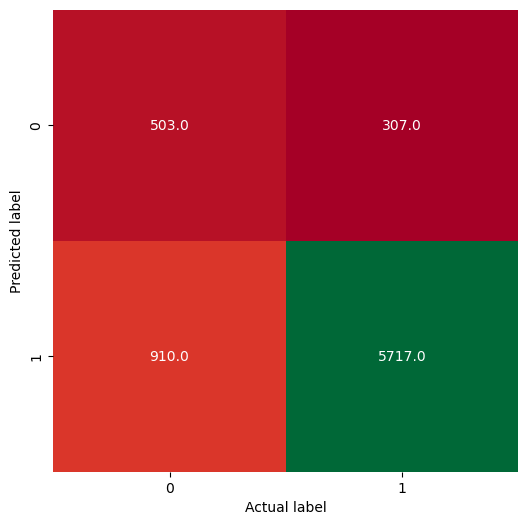

**************************************************


Values of True Positives, True Negatives, False Positivies and False Negatives
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True Positives: 5717
True Negatives: 503
False Positives: 307
False Negatives: 910
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Evaluation Score Summary
--------------------------------------------------
Accuracy Score: 0.84
Sensitivity/Recall Score: 0.86
Specificity Score: 0.62
Precision: 0.62
F1 Score: 0.72
--------------------------------------------------


[0.84, 0.86, 0.62, 0.62, 0.72]

In [90]:
eval_scores(rf_hpt, X_test, y_test)

In [91]:
# Fine tuning using Grid Search CV
rf_grid = {"n_estimators": [510],
           "max_depth": [20],
           "min_samples_split": [350, 400],
           "min_samples_leaf": [45, 50]}

In [92]:
# Setup random hyperparameter search for Random Forest Classifier
rf_hpt = GridSearchCV(RandomForestClassifier(random_state=42),
                                param_grid=rf_grid,
                                cv=5,
                                verbose=True,
                                n_jobs=-1)

# Fit random hyperparameter search model
rf_hpt.fit(X_train_sm, y_train_sm)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [20], 'min_samples_leaf': [45, 50],
                         'min_samples_split': [350, 400],
                         'n_estimators': [510]},
             verbose=True)

### HyperParameter tuned RF model

Visualizing the Confusion Matrix with a Heatmap


**************************************************


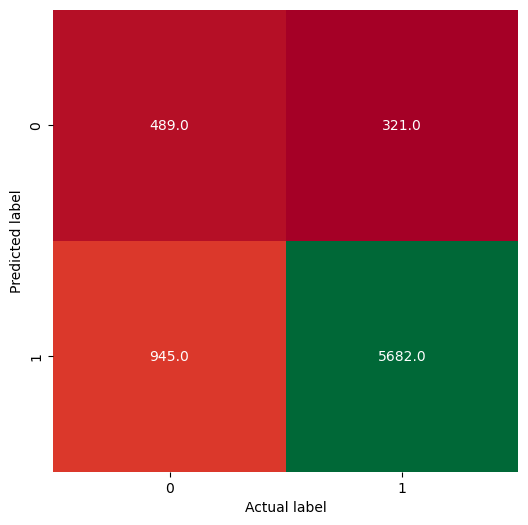

**************************************************


Values of True Positives, True Negatives, False Positivies and False Negatives
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True Positives: 5682
True Negatives: 489
False Positives: 321
False Negatives: 945
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Evaluation Score Summary
--------------------------------------------------
Accuracy Score: 0.83
Sensitivity/Recall Score: 0.86
Specificity Score: 0.6
Precision: 0.6
F1 Score: 0.71
--------------------------------------------------


In [93]:
# Getting the scores of the tuned model
rf_tuned_metrics = eval_scores(rf_hpt, X_test, y_test)

In [94]:
# Printing the scores of the base and tuned Random Forest model as reference
dict_rf_bt_metrics = {'Metrics': ['Accuracy','Sensitivity/Recall','Specificity','Precision','F1 Score'], 
                               'RF Base Model': rf_metrics,
                               'RF Tuned Model': rf_tuned_metrics}

df_rf_bt_metrics = pd.DataFrame(dict_rf_bt_metrics, columns = ['Metrics', 'RF Base Model', 'RF Tuned Model'])
df_rf_bt_metrics

,Metrics,RF Base Model,RF Tuned Model
0,Accuracy,0.91,0.83
1,Sensitivity/Recall,0.97,0.86
2,Specificity,0.43,0.60
3,Precision,0.43,0.60
4,F1 Score,0.60,0.71


### Saving the base and tuned models

In [95]:
rf_base_model = dump(rf, './pickle/rf_base_model.joblib')

In [96]:
rf_tuned_model = dump(rf_hpt, './pickle/rf_tuned_model.joblib')

***Conclusion:***

For Random Forest, Tuned Model is performing better than the base model.
We will consider the Tuned Model for evaluation purpose during model comparison.

# `XGBoost Classifier`

In [97]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_xg = le.fit_transform(y_train_sm)
xg = xgb.XGBClassifier(random_state=42).fit(X_train_sm, y_train_xg)

## Base Model

Visualizing the Confusion Matrix with a Heatmap


**************************************************


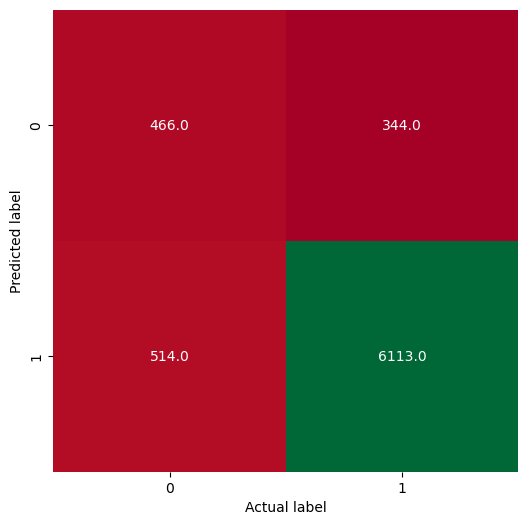

**************************************************


Values of True Positives, True Negatives, False Positivies and False Negatives
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True Positives: 6113
True Negatives: 466
False Positives: 344
False Negatives: 514
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Evaluation Score Summary
--------------------------------------------------
Accuracy Score: 0.88
Sensitivity/Recall Score: 0.92
Specificity Score: 0.58
Precision: 0.58
F1 Score: 0.71
--------------------------------------------------


In [98]:
# Getting the score of the base model
y_test_xg = le.fit_transform(y_test)
xg_metrics = eval_scores(xg, X_test, y_test_xg)

In [99]:
# Printing the scores of the base model as reference
df_xg_base_metrics = pd.DataFrame({'Metrics': ['Accuracy','Sensitivity/Recall','Specificity','Precision','F1 Score'], 'XG Base Model': xg_metrics},
                             columns = ['Metrics', 'XG Base Model']
                             )
df_xg_base_metrics

,Metrics,XG Base Model
0,Accuracy,0.88
1,Sensitivity/Recall,0.92
2,Specificity,0.58
3,Precision,0.58
4,F1 Score,0.71


In [100]:
xg_grid = {"learning_rate": np.arange(0.05, 1, 0.1),
           "max_depth": np.arange(5, 20, 5)
           }

In [101]:
# Setup random hyperparameter search for Random Forest Classifier
xg_hpt = RandomizedSearchCV(XGBClassifier(random_state=42),
                                param_distributions=xg_grid,
                                cv=4,
                                verbose=True,
                                n_jobs=-1)

# Fit random hyperparameter search model
xg_hpt.fit(X_train_sm, y_train_xg)

Fitting 4 folds for each of 10 candidates, totalling 40 fits


RandomizedSearchCV(cv=4,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           max_cat_to_onehot=None,
                            

In [102]:
# Checking the best parameters
xg_hpt.best_params_

{'max_depth': 15, 'learning_rate': 0.35000000000000003}

Visualizing the Confusion Matrix with a Heatmap


**************************************************


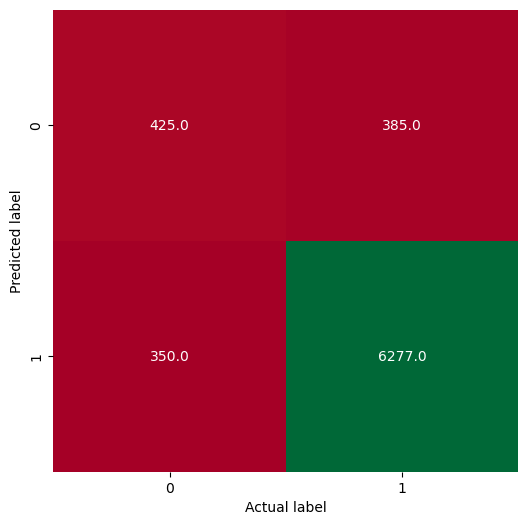

**************************************************


Values of True Positives, True Negatives, False Positivies and False Negatives
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True Positives: 6277
True Negatives: 425
False Positives: 385
False Negatives: 350
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Evaluation Score Summary
--------------------------------------------------
Accuracy Score: 0.9
Sensitivity/Recall Score: 0.95
Specificity Score: 0.52
Precision: 0.52
F1 Score: 0.67
--------------------------------------------------


[0.9, 0.95, 0.52, 0.52, 0.67]

In [103]:
eval_scores(xg_hpt, X_test, y_test_xg)

In [104]:
# Fine tuning with Grid Search CV
xg_grid = {"learning_rate": [0.45, 0.15],
           "max_depth": [5, 10]
           }

In [105]:
# Setup random hyperparameter search for Random Forest Classifier
xg_hpt = GridSearchCV(XGBClassifier(random_state=42),
                                param_grid=xg_grid,
                                cv=5,
                                verbose=True,
                                n_jobs=-1)

# Fit random hyperparameter search model
xg_hpt.fit(X_train_sm, y_train_xg)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max

In [106]:
# Check best parameters
xg_hpt.best_params_

{'learning_rate': 0.45, 'max_depth': 10}

### HyperParameter tuned model

Visualizing the Confusion Matrix with a Heatmap


**************************************************


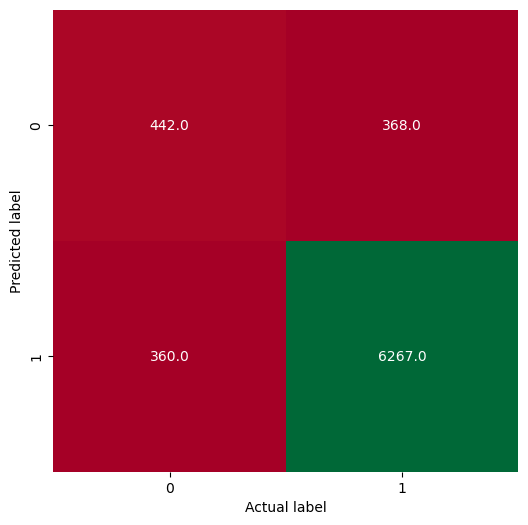

**************************************************


Values of True Positives, True Negatives, False Positivies and False Negatives
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
True Positives: 6267
True Negatives: 442
False Positives: 368
False Negatives: 360
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


Evaluation Score Summary
--------------------------------------------------
Accuracy Score: 0.9
Sensitivity/Recall Score: 0.95
Specificity Score: 0.55
Precision: 0.55
F1 Score: 0.7
--------------------------------------------------


In [107]:
# Getting the scores of the tuned model
xg_tuned_metrics = eval_scores(xg_hpt, X_test, y_test_xg)

In [108]:
# Printing the scores of the base and tuned XGBoost model as reference
dict_xg_bt_metrics = {'Metrics': ['Accuracy','Sensitivity/Recall','Specificity','Precision','F1 Score'], 
                               'XG Base Model': xg_metrics,
                               'XG Tuned Model': xg_tuned_metrics}

df_xg_bt_metrics = pd.DataFrame(dict_xg_bt_metrics, columns = ['Metrics', 'XG Base Model', 'XG Tuned Model'])
df_xg_bt_metrics

,Metrics,XG Base Model,XG Tuned Model
0,Accuracy,0.88,0.90
1,Sensitivity/Recall,0.92,0.95
2,Specificity,0.58,0.55
3,Precision,0.58,0.55
4,F1 Score,0.71,0.70


***Conclusion:***
* For XG Boost model, Base Model is performing better than the tuned model.
* We will consider the Base Model for evaluation purpose during model comparison.

### Saving the base and tuned models

In [109]:
xg_base_model = dump(xg, './pickle/xg_base_model.joblib')

In [110]:
xg_tuned_model = dump(xg_hpt, './pickle/xg_tuned_model.joblib')

# `Model Evaluation`

In [111]:
# Printing the scores of all the 3 Models (Base and Tuned)
dict_bt_metrics = {'Metrics': ['Accuracy','Sensitivity/Recall','Specificity','Precision','F1 Score'],
                              'LR Base Model': lr_metrics, 'LR Tuned Model': lr_tuned_metrics,
                              'RF Base Model': rf_metrics, 'RF Tuned Model': rf_tuned_metrics,
                              'XG Base Model': xg_metrics, 'XG Tuned Model': xg_tuned_metrics}

df_bt_metrics = pd.DataFrame(dict_bt_metrics, columns = ['Metrics', 'LR Base Model', 'LR Tuned Model', 'RF Base Model', 'RF Tuned Model', 'XG Base Model', 'XG Tuned Model'])
df_bt_metrics

,Metrics,LR Base Model,LR Tuned Model,RF Base Model,RF Tuned Model,XG Base Model,XG Tuned Model
0,Accuracy,0.87,0.89,0.91,0.83,0.88,0.90
1,Sensitivity/Recall,0.89,0.92,0.97,0.86,0.92,0.95
2,Specificity,0.73,0.57,0.43,0.60,0.58,0.55
3,Precision,0.73,0.57,0.43,0.60,0.58,0.55
4,F1 Score,0.80,0.70,0.60,0.71,0.71,0.70


In [112]:
# Saving the base logistic regression model as the best sentiment model for future use 
best_sentiment_model = dump(logreg, './pickle/best_sentiment_model.joblib')

# Building a Recommendation System


## Import data

In [113]:
df_recomm = pd.read_csv("sample30.csv")

In [114]:
df_recomm.shape

(30000, 15)

In [115]:
# We need only few columns for building a recommendation system
df_recomm = df_recomm[["id", "name", "reviews_rating", "reviews_username"]]

In [116]:
df_recomm.shape

(30000, 4)

In [117]:
df_recomm.head(5)

,id,name,reviews_rating,reviews_username
0,AV13O1A8GV-KLJ3akUyj,Pink Friday: Roman Reloaded Re-Up (w/dvd),5,joshua
1,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,5,dorothy w
2,AV14LG0R-jtxr-f38QfS,Lundberg Organic Cinnamon Toast Rice Cakes,5,dorothy w
3,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,1,rebecca
4,AV16khLE-jtxr-f38VFn,K-Y Love Sensuality Pleasure Gel,1,walker557


#### Handling the NULL values

In [118]:
# Getting total number of NULL values and percentage of the columns
null_count = df_recomm[df_recomm.columns[df_recomm.isna().any()]].isna().sum().sort_values(ascending=False)
null_perc = (df_recomm[df_recomm.columns[df_recomm.isna().any()]].isna().sum() * 100 / df_recomm.shape[0]).sort_values(ascending=False)
null_data = pd.concat([null_count, null_perc], axis=1, keys=['Count', 'Percentage'])
null_data

,Count,Percentage
reviews_username,63,0.21


In [119]:
# Removing the rows where reviews_username is NULL
df_recomm = df_recomm[~ df_recomm.reviews_username.isna() ]

In [120]:
df_recomm.shape

(29937, 4)

In [121]:
# Getting total number of NULL values and percentage of the columns
null_count = df_recomm[df_recomm.columns[df_recomm.isna().any()]].isna().sum().sort_values(ascending=False)
null_perc = (df_recomm[df_recomm.columns[df_recomm.isna().any()]].isna().sum() * 100 / df_recomm.shape[0]).sort_values(ascending=False)
null_data = pd.concat([null_count, null_perc], axis=1, keys=['Count', 'Percentage'])
null_data

,Count,Percentage


### Split Train and Test 

In [122]:
train, test = train_test_split(df_recomm, test_size=0.30, random_state=42)

In [123]:
print(train.shape)
print(test.shape)

(20955, 4)
(8982, 4)


In [124]:
train.head(5)

,id,name,reviews_rating,reviews_username
962,AV1YGDqsGV-KLJ3adc-O,Windex Original Glass Cleaner Refill 67.6oz (2...,5,brittney w
10463,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 1...,5,cjshrad
25385,AVpfPaoqLJeJML435Xk9,Godzilla 3d Includes Digital Copy Ultraviolet ...,5,zman69
27096,AVpfrFDZLJeJML43Bmv0,Meguiar's Ultimate Quik Detailer 22-Oz.,5,misunshyne
24007,AVpfPaoqLJeJML435Xk9,Godzilla 3d Includes Digital Copy Ultraviolet ...,4,matanovatos


In [125]:
# Pivot the train ratings' dataset into matrix format in which columns are Products and the rows are usernames.
df_pivot = train.pivot_table(
    index='reviews_username',
    columns='id',
    values='reviews_rating'
).fillna(0)

df_pivot.head(3)

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01impala,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02dakota,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Creating a dummy train & dummy test dataset

In [126]:
# Copy the train dataset into dummy_train
dummy_train = train.copy()

In [127]:
# The products not rated by user is marked as 1 for prediction. 
dummy_train['reviews_rating'] = dummy_train['reviews_rating'].apply(lambda x: 0 if x>=1 else 1)

In [128]:
# Convert the dummy train dataset into matrix format
dummy_train = dummy_train.pivot_table(
    index='reviews_username',
    columns='id',
    values='reviews_rating'
).fillna(1)

dummy_train.head(3)

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
01impala,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
02dakota,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [129]:
dummy_train.head(5)

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
01impala,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
02dakota,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
02deuce,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
0325home,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


## `User Similarity Matrix` 

In [130]:
# Pivot the train ratings' dataset into matrix format in which columns are Products and the rows are usernames.
df_pivot = train.pivot_table(
    index='reviews_username',
    columns='id',
    values='reviews_rating'
)

In [131]:
# For verification purpose, we do have cases where the rating is not NaN
df_pivot[~df_pivot['AV13O1A8GV-KLJ3akUyj'].isna()]

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
joshua,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Normalising the rating of the product for each user

In [132]:
mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T

In [133]:
df_subtracted.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01impala,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02dakota,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02deuce,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0325home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Finding Cosine similarity

In [134]:
# Creating the User Similarity Matrix using pairwise_distance function.
user_corr = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
user_corr[np.isnan(user_corr)] = 0
print(user_corr)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [135]:
user_corr.shape

(18275, 18275)

## `Prediction - User Based`

In [136]:
user_corr[user_corr<0]=0
user_corr

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [137]:
user_predicted_ratings = np.dot(user_corr, df_pivot.fillna(0))
user_predicted_ratings

array([[0.        , 0.        , 2.5       , ..., 1.46525748, 1.88982237,
        0.20412415],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [138]:
user_predicted_ratings.shape

(18275, 256)

In [139]:
user_final_rating = np.multiply(user_predicted_ratings,dummy_train)
user_final_rating.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,2.5,3.596262,0.0,0.0,0.0,0.0,2.581989,1.018079,...,1.666667,0.188982,0.0,0.0,0.0,0.0,0.0,1.465257,1.889822,0.204124
01impala,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
02dakota,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
02deuce,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
0325home,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000


## `User based Recommendation`

In [140]:
# Take a sample username as input.
user_input = '00sab00'

In [141]:
top20_recommendations = user_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
df_top20_recommendations = pd.DataFrame({'Product Id': top20_recommendations.index, 'cosine_similarity_score' : top20_recommendations})
df_top20_recommendations.reset_index(drop=True, inplace=True)
df_top20_recommendations

,Product Id,cosine_similarity_score
0,AVpfPaoqLJeJML435Xk9,37.472929
1,AVpfRTh1ilAPnD_xYic2,29.191053
2,AVpf0eb2LJeJML43EVSt,14.259486
3,AVpf3VOfilAPnD_xjpun,12.313738
4,AVpf2tw1ilAPnD_xjflC,11.178377
5,AVpfBrUZilAPnD_xTUly,7.831663
6,AVpfov9TLJeJML43A7B0,6.623441
7,AVpf385g1cnluZ0-s0_t,6.253560
8,AVpfM_ytilAPnD_xXIJb,6.154565
9,AVpfR5m0LJeJML436K3W,5.650706


In [142]:
top20_rec = pd.merge(df_recomm, df_top20_recommendations,left_on='id',right_on='Product Id', how = 'inner')[['Product Id', 'name', 'cosine_similarity_score']].drop_duplicates()
top20_rec.reset_index(drop=True, inplace=True)
top20_rec.sort_values(by='cosine_similarity_score', ascending=False)

,Product Id,name,cosine_similarity_score
16,AVpfPaoqLJeJML435Xk9,Godzilla 3d Includes Digital Copy Ultraviolet ...,37.472929
19,AVpfRTh1ilAPnD_xYic2,Planes: Fire Rescue (2 Discs) (includes Digita...,29.191053
2,AVpf0eb2LJeJML43EVSt,The Resident Evil Collection 5 Discs (blu-Ray),14.259486
6,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 1...,12.313738
4,AVpf2tw1ilAPnD_xjflC,Red (special Edition) (dvdvideo),11.178377
9,AVpfBrUZilAPnD_xTUly,"Coty Airspun Face Powder, Translucent Extra Co...",7.831663
15,AVpfov9TLJeJML43A7B0,Bisquick Original Pancake And Baking Mix - 40oz,6.623441
5,AVpf385g1cnluZ0-s0_t,"Hormel Chili, No Beans",6.253560
11,AVpfM_ytilAPnD_xXIJb,Tostitos Bite Size Tortilla Chips,6.154565
18,AVpfR5m0LJeJML436K3W,Jason Aldean - They Don't Know,5.650706


## `Evaluation - User Based`

In [143]:
train.head(2)

,id,name,reviews_rating,reviews_username
962,AV1YGDqsGV-KLJ3adc-O,Windex Original Glass Cleaner Refill 67.6oz (2...,5,brittney w
10463,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 1...,5,cjshrad


In [144]:
# Find out the common users of test and train dataset.
common = test[test.reviews_username.isin(train.reviews_username)]
common.shape

(2051, 4)

In [145]:
common.head(2)

,id,name,reviews_rating,reviews_username
12875,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 1...,5,jessica
21657,AVpfm8yiLJeJML43AYyu,Nexxus Exxtra Gel Style Creation Sculptor,1,romance318


In [146]:
# convert into the user-product matrix.
common_user_based_matrix = common.pivot_table(index='reviews_username', columns='id', values='reviews_rating')

In [147]:
common_user_based_matrix.head(2)

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YneDPglJLPUi8IJyQ,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZT7GLglJLPUi8IQLI,...,AVpfov9TLJeJML43A7B0,AVpfpM2yilAPnD_xfmDG,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS
reviews_username,,,,,,,,,,,,,,,,,,,,,
1234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1234567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [148]:
# Convert the user_corr matrix into dataframe.
user_corr_df = pd.DataFrame(user_corr)

In [149]:
user_corr_df.head(2)

,0,1,2,3,4,5,6,7,8,9,...,18265,18266,18267,18268,18269,18270,18271,18272,18273,18274
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [150]:
df_subtracted.head(1)

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [151]:
user_corr_df['userId'] = df_subtracted.index
user_corr_df.set_index('userId',inplace=True)
user_corr_df.head(2)

,0,1,2,3,4,5,6,7,8,9,...,18265,18266,18267,18268,18269,18270,18271,18272,18273,18274
userId,,,,,,,,,,,,,,,,,,,,,
00sab00,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
01impala,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [152]:
common.head(1)

,id,name,reviews_rating,reviews_username
12875,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 1...,5,jessica


In [153]:
list_name = common.reviews_username.tolist()

user_corr_df.columns = df_pivot.index.tolist()
user_corr_df_1 =  user_corr_df[user_corr_df.index.isin(list_name)]

In [154]:
user_corr_df_1.shape

(1693, 18275)

In [155]:
user_corr_df_2 = user_corr_df_1.T[user_corr_df_1.T.index.isin(list_name)]

In [156]:
user_corr_df_3 = user_corr_df_2.T

In [157]:
user_corr_df_3.head()

,1234,1234567,123charlie,1943,1witch,4 rooms 1 dog lotsa fur,85lisa,a hutch,aac06002,aalyah,...,xavier,yamel97,yayawomack,yorkielvr,yummy,yvonne,zach,zebras,zippy,zxcsdfd
userId,,,,,,,,,,,,,,,,,,,,,
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123charlie,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1943,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1witch,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [158]:
user_corr_df_3.shape

(1693, 1693)

In [159]:
user_corr_df_3[user_corr_df_3<0]=0

common_user_predicted_ratings = np.dot(user_corr_df_3, common_user_based_matrix.fillna(0))
common_user_predicted_ratings

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [160]:
common.head(2)

,id,name,reviews_rating,reviews_username
12875,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 1...,5,jessica
21657,AVpfm8yiLJeJML43AYyu,Nexxus Exxtra Gel Style Creation Sculptor,1,romance318


In [161]:
# Creating dummy test dataframe
dummy_test = common.copy()

dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)

dummy_test = dummy_test.pivot_table(index='reviews_username', columns='id', values='reviews_rating').fillna(0)

In [162]:
dummy_test.shape

(1693, 140)

In [163]:
common_user_predicted_ratings = np.multiply(common_user_predicted_ratings,dummy_test)

In [164]:
common_user_predicted_ratings.head(2)

id,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YneDPglJLPUi8IJyQ,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZT7GLglJLPUi8IQLI,...,AVpfov9TLJeJML43A7B0,AVpfpM2yilAPnD_xfmDG,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS
reviews_username,,,,,,,,,,,,,,,,,,,,,
1234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1234567,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


* Calculating the RMSE for only the products rated by user.
* For RMSE, normalising the rating to (1,5) range.

In [165]:
from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = common_user_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [166]:
common_ = common.pivot_table(index='reviews_username', columns='id', values='reviews_rating')

In [167]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

#### RMSE (Root Mean Square Error) for User Based recommendation system

In [168]:
rmse_user_user = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse_user_user)

2.551419404666111


## `Item Similarity Matrix`

In [169]:
df_pivot = train.pivot_table(
    index='reviews_username',
    columns='id',
    values='reviews_rating'
).T

In [170]:
df_pivot.head()

reviews_username,00sab00,01impala,02dakota,02deuce,0325home,06stidriver,08dallas,09mommy11,1.11E+24,1085,...,zsarah,zsazsa,zubb,zuttle,zwithanx,zxcsdfd,zxjki,zyiah4,zzdiane,zzz1127
id,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV14LG0R-jtxr-f38QfS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV16khLE-jtxr-f38VFn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YGDqsGV-KLJ3adc-O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YIch7GV-KLJ3addeG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Normalizing the product rating for each product 

In [171]:
mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T

In [172]:
df_subtracted.head()

reviews_username,00sab00,01impala,02dakota,02deuce,0325home,06stidriver,08dallas,09mommy11,1.11E+24,1085,...,zsarah,zsazsa,zubb,zuttle,zwithanx,zxcsdfd,zxjki,zyiah4,zzdiane,zzz1127
id,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV14LG0R-jtxr-f38QfS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV16khLE-jtxr-f38VFn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YGDqsGV-KLJ3adc-O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YIch7GV-KLJ3addeG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [173]:
# Item Similarity Matrix
item_corr = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
item_corr[np.isnan(item_corr)] = 0
print(item_corr)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [174]:
item_corr[item_corr<0]=0
item_corr

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

## `Prediction - Item Based`

In [175]:
item_predicted_ratings = np.dot((df_pivot.fillna(0).T),item_corr)
item_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.00603917, 0.06485571,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.0094556 ],
       [0.        , 0.        , 0.        , ..., 0.00781596, 0.10809285,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00756448]])

In [176]:
item_predicted_ratings.shape

(18275, 256)

In [177]:
dummy_train.shape

(18275, 256)

#### Filtering the rating only for the products not rated by the user for recommendation

In [178]:
item_final_rating = np.multiply(item_predicted_ratings,dummy_train)
item_final_rating.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,0.0,0.006042,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.020509,0.006039,0.064856,0.000000
01impala,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.097645,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
02dakota,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.162741,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
02deuce,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.130193,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
0325home,0.0,0.0,0.0,0.000082,0.0,0.0,0.0,0.001244,0.002197,0.001808,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.006084,0.000000,0.000000,0.009456


In [179]:
# Take a sample username as input.
user_input = '00sab00'

In [180]:
item_final_rating.head(2)

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,0.0,0.006042,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.020509,0.006039,0.064856,0.0
01impala,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.097645,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0


In [181]:
top20_item_recomms = item_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
df_top_20_item_recomms = pd.DataFrame({'Product Id': top20_item_recomms.index, 'cosine_similarity_score' : top20_item_recomms})
df_top_20_item_recomms.reset_index(drop=True, inplace=True)
df_top_20_item_recomms

,Product Id,cosine_similarity_score
0,AVpfE7puilAPnD_xUcCW,0.147125
1,AVpfv4TlilAPnD_xhjNS,0.064856
2,AVpfJcHuLJeJML433ZrY,0.052161
3,AVpf0thK1cnluZ0-r8vR,0.036554
4,AVpe6PCDLJeJML43yFQH,0.032108
5,AVpe_dxlilAPnD_xSiHI,0.030764
6,AVpfQtEm1cnluZ0-hUpe,0.027387
7,AVpfHf4wLJeJML432vqK,0.022930
8,AVpfthSailAPnD_xg3ON,0.020509
9,AVpe6FfKilAPnD_xQmHi,0.020308


## `Item based recommendation`

In [182]:
top20_item_rec = pd.merge(df_recomm, df_top_20_item_recomms,left_on='id',right_on='Product Id', how = 'inner')[['Product Id', 'name', 'cosine_similarity_score']].drop_duplicates()
top20_item_rec.reset_index(drop=True, inplace=True)
top20_item_rec.sort_values(by='cosine_similarity_score', ascending=False)

,Product Id,name,cosine_similarity_score
11,AVpfE7puilAPnD_xUcCW,Bilbao Nightstand Gray Oak - South Shore,0.147125
19,AVpfv4TlilAPnD_xhjNS,Various - Red Hot Blue:Tribute To Cole Porter ...,0.064856
13,AVpfJcHuLJeJML433ZrY,Equals (blu-Ray),0.052161
8,AVpf0thK1cnluZ0-r8vR,100:Complete First Season (blu-Ray),0.036554
6,AVpe6PCDLJeJML43yFQH,Wagan Smartac 80watt Inverter With Usb,0.032108
0,AVpe_dxlilAPnD_xSiHI,"The Seaweed Bath Co. Argan Conditioner, Smooth...",0.030764
17,AVpfQtEm1cnluZ0-hUpe,Jolly Time Select Premium Yellow Pop Corn,0.027387
12,AVpfHf4wLJeJML432vqK,Trend Lab Park Nursing Cover - Paisley,0.022930
18,AVpfthSailAPnD_xg3ON,"Musselman Apple Sauce, Cinnamon, 48oz",0.020509
4,AVpe6FfKilAPnD_xQmHi,Chex Muddy Buddies Brownie Supreme Snack Mix,0.020308


## `Evaluation - Item Based`

In [183]:
test.columns

Index(['id', 'name', 'reviews_rating', 'reviews_username'], dtype='object')

In [184]:
# Find out the common products of test and train dataset.
common = test[test.id.isin(train.id)]
common.shape

(8966, 4)

In [185]:
common.head(2)

,id,name,reviews_rating,reviews_username
25787,AVpfPaoqLJeJML435Xk9,Godzilla 3d Includes Digital Copy Ultraviolet ...,5,youknowhowitgoes
12627,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 1...,5,ashleydale00


In [186]:
common_item_based_matrix = common.pivot_table(index='reviews_username', columns='id', values='reviews_rating').T

In [187]:
common_item_based_matrix.shape

(195, 8318)

In [188]:
item_corr_df = pd.DataFrame(item_corr)

In [189]:
item_corr_df.head(2)

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [190]:
item_corr_df['movieId'] = df_subtracted.index
item_corr_df.set_index('movieId',inplace=True)
item_corr_df.head()

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
movieId,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV14LG0R-jtxr-f38QfS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV16khLE-jtxr-f38VFn,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YGDqsGV-KLJ3adc-O,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YIch7GV-KLJ3addeG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [191]:
list_name = common.id.tolist()

In [192]:
item_corr_df.columns = df_subtracted.index.tolist()

item_corr_df_1 =  item_corr_df[item_corr_df.index.isin(list_name)]

In [193]:
item_corr_df_2 = item_corr_df_1.T[item_corr_df_1.T.index.isin(list_name)]

item_corr_df_3 = item_corr_df_2.T

In [194]:
item_corr_df_3.head(2)

,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1YqAaMGV-KLJ3adiDj,...,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
movieId,,,,,,,,,,,,,,,,,,,,,
AV16khLE-jtxr-f38VFn,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV1YGDqsGV-KLJ3adc-O,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.108098,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [195]:
item_corr_df_3[item_corr_df_3<0]=0

common_item_predicted_ratings = np.dot(item_corr_df_3, common_item_based_matrix.fillna(0))
common_item_predicted_ratings

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.34691174e-02, 3.00000000e+00, 6.62104097e-03, ...,
        0.00000000e+00, 5.16904870e-03, 8.22214474e-05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 9.45559849e-03]])

In [196]:
common_item_predicted_ratings.shape

(195, 8318)

In [197]:
common.head(2)

,id,name,reviews_rating,reviews_username
25787,AVpfPaoqLJeJML435Xk9,Godzilla 3d Includes Digital Copy Ultraviolet ...,5,youknowhowitgoes
12627,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 1...,5,ashleydale00


In [198]:
# Dummy test will be used for evaluation
dummy_test = common.copy()

dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)

dummy_test = dummy_test.pivot_table(index='reviews_username', columns='id', values='reviews_rating').T.fillna(0)

common_item_predicted_ratings = np.multiply(common_item_predicted_ratings,dummy_test)

In [199]:
common_ = common.pivot_table(index='reviews_username', columns='id', values='reviews_rating').T

In [200]:
from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = common_item_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan  1. nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [201]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

RMSE (Root Mean Square Error) for Item-Item recommendation system

In [202]:
rmse_item_item = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse_item_item)

3.543672614922191


# `Best-suited Recommendation model`

In [203]:
# Recommended model evaluation
if rmse_user_user < rmse_item_item:
  print("Best-fit model is user-user recommendation system")
else:
  print("Best-fit model is item-item recommendation system")

Best-fit model is user-user recommendation system


## Top 20 Product recommendations to the user by the best recommendation model 

In [204]:
# Take a sample username as input
user_input = 'evrydayhustla420'

In [205]:
top20_recommendations = user_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
df_top20_recommendations = pd.DataFrame({'Product Id': top20_recommendations.index, 'cosine_similarity_score' : top20_recommendations})
df_top20_recommendations.reset_index(drop=True, inplace=True)
df_top20_recommendations

,Product Id,cosine_similarity_score
0,AVpfRTh1ilAPnD_xYic2,16.870920
1,AVpe41TqilAPnD_xQH3d,13.017496
2,AVpf0eb2LJeJML43EVSt,11.843501
3,AVpf3VOfilAPnD_xjpun,9.609059
4,AVpe59io1cnluZ0-ZgDU,7.706569
5,AVpfJP1C1cnluZ0-e3Xy,5.474655
6,AVpfOIrkilAPnD_xXgDG,4.809401
7,AVpfPnrU1cnluZ0-g9rL,4.539020
8,AVpe31o71cnluZ0-YrSD,4.336229
9,AVpe8gsILJeJML43y6Ed,4.309060


In [206]:
top20_rec = pd.merge(df_recomm, df_top20_recommendations,left_on='id',right_on='Product Id', how = 'inner')[['Product Id', 'name', 'cosine_similarity_score']].drop_duplicates()
top20_rec.reset_index(drop=True, inplace=True)
top20_rec.sort_values(by='cosine_similarity_score', ascending=False)

,Product Id,name,cosine_similarity_score
18,AVpfRTh1ilAPnD_xYic2,Planes: Fire Rescue (2 Discs) (includes Digita...,16.870920
1,AVpe41TqilAPnD_xQH3d,Mike Dave Need Wedding Dates (dvd + Digital),13.017496
5,AVpf0eb2LJeJML43EVSt,The Resident Evil Collection 5 Discs (blu-Ray),11.843501
8,AVpf3VOfilAPnD_xjpun,Clorox Disinfecting Wipes Value Pack Scented 1...,9.609059
2,AVpe59io1cnluZ0-ZgDU,My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Di...,7.706569
12,AVpfJP1C1cnluZ0-e3Xy,Clorox Disinfecting Bathroom Cleaner,5.474655
15,AVpfOIrkilAPnD_xXgDG,Alex Cross (dvdvideo),4.809401
17,AVpfPnrU1cnluZ0-g9rL,Stargate (ws) (ultimate Edition) (director's C...,4.539020
0,AVpe31o71cnluZ0-YrSD,Dark Shadows (includes Digital Copy) (ultravio...,4.336229
3,AVpe8gsILJeJML43y6Ed,"Pendaflex174 Divide It Up File Folder, Multi S...",4.309060


# Saving the best recommendation model

In [207]:
user_final_rating.shape

(18275, 256)

In [208]:
user_final_rating.head(2)

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,...,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,
00sab00,0.0,0.0,2.5,3.596262,0.0,0.0,0.0,0.0,2.581989,1.018079,...,1.666667,0.188982,0.0,0.0,0.0,0.0,0.0,1.465257,1.889822,0.204124
01impala,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000


In [209]:
best_recommendation_model = joblib.dump(user_final_rating.astype('float32'), './models/best_recommendation_model.pkl')

# Fine-Tuning the Recommendation System and Recommendation of Top 5 Products

In [210]:
# Create function to recommend top 5 products to any user
def product_recommendations_user(user_name):
  if user_name not in user_final_rating.index:
    print(f"The User {user_name} does not exist. Please provide a valid user name")
  else:
    # Get top 20 recommended products from the best recommendation model
    top20_recommended_products = list(user_final_rating.loc[user_name].sort_values(ascending=False)[0:20].index)
    # Get only the recommended products from the prepared dataframe "df_sentim"
    df_top20_products = df_sentim[df_sentim.id.isin(top20_recommended_products)]
    # For these 20 products, get their user reviews and pass them through TF-IDF vectorizer to convert the data into suitable format for modeling
    X = tfidf.transform(df_top20_products["reviews_lemmatized"].values.astype(str))
    # Use the best sentiment model to predict the sentiment for these user reviews
    df_top20_products['predicted_sentiment'] = logreg.predict(X)
    # Create a new column to map Positive sentiment to 1 and Negative sentiment to 0. This will allow us to easily summarize the data
    df_top20_products['positive_sentiment'] = df_top20_products['predicted_sentiment'].apply(lambda x: 1 if x=="Positive" else 0)
    df_top20_products = df_top20_products[['name','predicted_sentiment','positive_sentiment']]
    # Create a new dataframe "pred_df" to store the count of positive user sentiments
    pred_df = df_top20_products.groupby(by='name').sum()
    
    pred_df['pos_sent_count'] = df_top20_products.groupby(by='name')['positive_sentiment'].count()
    # Create a column to measure the total sentiment count
    pred_df['total_sent_count'] = df_top20_products.groupby(by='name')['predicted_sentiment'].count()
    # Create a column that measures the % of positive user sentiment for each product review
    pred_df['post_sent_percentage'] = np.round(pred_df['pos_sent_count']/pred_df['total_sent_count']*100,2)
    
    # Return top 5 recommended products to the user
    result = pred_df.sort_values(by='post_sent_percentage', ascending=False)[:5]
    return result

# Top 5 Products Recommendation

In [211]:
# Take a sample username as input
user_input = 'rebecca'
print(f"Printing the top 5 recommended products for the user: {user_input} along with each product's positive sentiment count, overall review count and positive sentiment %")
print("\n")
top5_reco_sent_reco_user = product_recommendations_user(user_input)
top5_reco_sent_reco_user

Printing the top 5 recommended products for the user: rebecca along with each product's positive sentiment count, overall review count and positive sentiment %




,positive_sentiment,pos_sent_count,total_sent_count,post_sent_percentage
name,,,,
"Australian Gold Exotic Blend Lotion, SPF 4",25,34,34,100.0
"Pendaflex174 Divide It Up File Folder, Multi Section, Letter, Assorted, 12/pack",218,310,310,100.0
"Vicks Vaporub, Regular, 3.53oz",39,96,96,100.0
Vaseline Intensive Care Lip Therapy Cocoa Butter,135,158,158,100.0
Tostitos Bite Size Tortilla Chips,184,264,264,100.0
